In [1]:
from importlib.metadata import version
import torch
import summa
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from collections import Counter
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print((len(data)))
data.sample(10)

98401


,headlines,text
49113,Video: Women thrash drunk H'yana cop for alleg...,A video showing two women thrash a drunk polic...
55415,"Passengers caught smuggling gold, saffron at D...",Passengers have been caught smuggling gold and...
49565,"2018 Budget is progressive, balanced: Ola Co-f...",Ola's Co-founder Bhavish Aggarwal has said tha...
86413,UK police make 12 arrests after London bridge ...,London Metropolitan police on Sunday arrested ...
14291,Don't remember any such act: Kailash Kher on h...,After two female journalists accused Kailash K...
34551,Bailable warrant against Salman cancelled in h...,A Mumbai court on Saturday cancelled the baila...
5238,"Odisha CM announces Ã¢ÂÂ¹10,000 cr KALIA sche...",Odisha CM Naveen Patnaik on Friday announced a...
2796,Won't allow Indian TV shows as they damage cul...,Indian content won't be aired on television ch...
14108,I wasn't even born 20yrs ago: Abhijeet on sexu...,Responding to a former air hostess' claims tha...
31390,SRK's 'Zero' to be filmed at the US Space & Ro...,The Shah Rukh Khan starrer 'Zero' will be film...


데이터 전처리하기 (추상적 요약)

In [3]:
#데이터 중복제거
data = data[['headlines','text']]
data.head()

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [4]:
#정규화 사전 
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [5]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [6]:
# 전체 데이터에 대한 전처리
clean_text = []
clean_headlines = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

print("text 전처리 후 결과: ", clean_text[:5])
print("headlines 전처리 후 결과: ", clean_headlines[:5])

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
#data.replace('', np.nan, inplace=True)
#print('=3')



text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


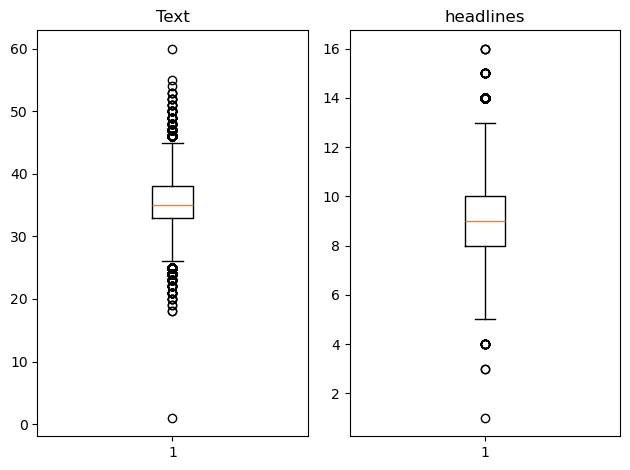

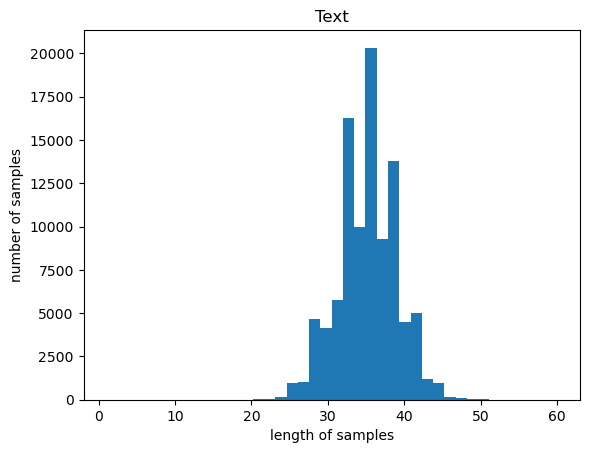

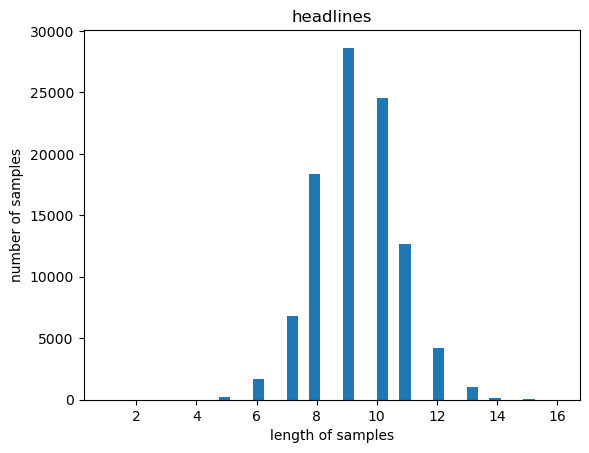

In [7]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
text_max_len = 50
headlines_max_len = 15

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653


In [9]:
#지정한 수보다 길면 제외
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98343


In [10]:
#healine 데이터에 시작 토큰과 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [11]:
#훈련 / 테스트 데이터 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19668
훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


단어 집합 만들기 및 정수 인코딩

In [12]:
def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [13]:
threshold = 7

# 전처리된 데이터 사용
text_data = data['text'].tolist()
headlines_data = data['headlines'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 76299
등장 빈도가 6번 이하인 희귀 단어의 수: 51752
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24547
단어 집합에서 희귀 단어의 비율: 67.82788765252494
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0339307246979774


In [14]:
src_vocab_size = 8000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

In [15]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[1900, 51, 4587, 676, 2, 3598, 1532, 1556, 326, 11, 2380, 25, 692, 1533, 34, 954, 4587, 81, 199, 25, 4321, 5199, 807, 431, 138, 1023, 1, 36, 2367, 676, 344, 343, 2675, 1892, 326, 36, 4516, 1, 189, 217], [4588, 28, 5068, 4965, 4262, 376, 151, 2, 151, 5, 1002, 139, 4771, 18, 2050, 6899, 751, 95, 1002, 2958, 1096, 673, 28, 5068, 4965, 1232, 779, 27, 13, 271, 67, 519], [329, 35, 1242, 4655, 574, 471, 32, 199, 32, 52, 4772, 1465, 2245, 60, 1, 43, 349, 1679, 1112, 42, 2877, 1, 1538, 6427, 6714, 7795, 2081, 4074, 1, 471, 1271, 680, 1, 124]]
[[168, 76, 1017, 1242, 158, 4215, 86, 65, 862, 235, 3652, 650, 4247, 2725, 1, 2637, 650, 141, 1793, 1149, 163, 6440, 2632, 7761, 2114, 7765, 1854, 2090, 1580, 514, 4023, 2725, 1055, 23, 443, 2], [1222, 406, 308, 1, 1580, 993, 3855, 7198, 3034, 1, 5272, 41, 1278, 2973, 406, 1, 305, 1827, 2522, 664, 217, 881, 2192, 7687, 374, 7799, 472, 2522, 9, 763, 1278, 2973, 87, 1, 55, 905], [82, 1519, 2396, 656, 245, 569, 46, 610, 4125, 3311, 657, 4973, 82, 167, 21, 23

In [16]:
def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)

In [17]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30105
등장 빈도가 5번 이하인 희귀 단어의 수: 19689
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10416
단어 집합에서 희귀 단어의 비율: 65.40109616342801
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.641198690444018


In [18]:
tar_vocab_size = 2000
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 227, 1427, 8, 1724, 63, 1793, 24, 703, 1, 1], [2, 1, 7, 37, 1, 1, 1961, 935], [2, 1084, 1, 1, 6, 158, 4, 1, 1617, 4, 707], [2, 497, 153, 123, 7, 202, 1, 4, 916, 1], [2, 136, 4, 1, 1, 5, 1, 263, 1, 65]]
target
decoder  [[227, 1427, 8, 1724, 63, 1793, 24, 703, 1, 1, 3], [1, 7, 37, 1, 1, 1961, 935, 3], [1084, 1, 1, 6, 158, 4, 1, 1617, 4, 707, 3], [497, 153, 123, 7, 202, 1, 4, 916, 1, 3], [136, 4, 1, 1, 5, 1, 263, 1, 65, 3]]


In [19]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [20]:
#패딩하기
from torch.nn.utils.rnn import pad_sequence

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=headlines_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=headlines_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=headlines_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=headlines_max_len)

어텐션 메커니즘 사용하기 (추상적 요약)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

# 디코더 설계
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [22]:
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(2000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2000, bias=True)
)


모델 훈련

In [23]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Hyperparameters
batch_size = 256
epochs = 50
learning_rate = 0.001
patience = 2

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Using device: cuda
Epoch 1/50 | Train Loss: 5.0128 | Val Loss: 4.7797
Epoch 2/50 | Train Loss: 4.6478 | Val Loss: 4.4334
Epoch 3/50 | Train Loss: 4.2772 | Val Loss: 4.0850
Epoch 4/50 | Train Loss: 3.9806 | Val Loss: 3.8501
Epoch 5/50 | Train Loss: 3.7498 | Val Loss: 3.6641
Epoch 6/50 | Train Loss: 3.5647 | Val Loss: 3.5349
Epoch 7/50 | Train Loss: 3.4163 | Val Loss: 3.4328
Epoch 8/50 | Train Loss: 3.2916 | Val Loss: 3.3503
Epoch 9/50 | Train Loss: 3.1793 | Val Loss: 3.2815
Epoch 10/50 | Train Loss: 3.0817 | Val Loss: 3.2231
Epoch 11/50 | Train Loss: 2.9939 | Val Loss: 3.1790
Epoch 12/50 | Train Loss: 2.9144 | Val Loss: 3.1460
Epoch 13/50 | Train Loss: 2.8412 | Val Loss: 3.1257
Epoch 14/50 | Train Loss: 2.7739 | Val Loss: 3.1036
Epoch 15/50 | Train Loss: 2.7134 | Val Loss: 3.0959
Epoch 16/50 | Train Loss: 2.6561 | Val Loss: 3.0887
Epoch 17/50 | Train Loss: 2.6044 | Val Loss: 3.0814
Epoch 18/50 | Train Loss: 2.5529 | Val Loss: 3.0746
Epoch 19/50 | Train Loss: 2.5063 | Val Loss: 3.0765
Ep

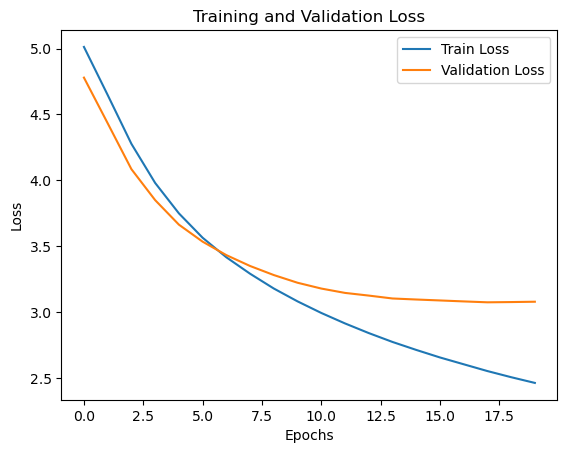

In [24]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

인퍼런스 모델

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder.to(device)

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)


def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

실제 결과와 요약문 비교하기 (추상적 요약)

In [26]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

In [27]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거


for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 요약 :", decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device))
    print("\n")

원문 : <UNK> contract manufacturer <UNK> reportedly begin <UNK> top end iphones india plant tamil nadu <UNK> <UNK> invest crore expand plant including investment iphone production tamil nadu industries minister <UNK> <UNK> said apple <UNK> se models india <UNK> local unit bengaluru
실제 요약 : <UNK> may begin <UNK> top end <UNK> in india in
예측 요약 :  only bank top of million million it against all cr <PAD> home home home


원문 : crew aboard international space station enough supplies last least six months vladimir <UNK> flight director iss russian segment said sunday three astronauts aboard iss due return earth december may face delay owing failure <UNK> rocket russia temporarily suspended manned space <UNK>
실제 요약 : <UNK> crew has enough <UNK> for months russian official
예측 요약 :  last leader ceo user user did billion president ban ceo court home gets home


원문 : akshay kumar shah rukh khan anupam kher huma qureshi among bollywood celebrities slammed terror attack pilgrims returning amarnath ya

C:\Users\user\AppData\Local\Temp\ipykernel_22848\532943321.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
C:\Users\user\AppData\Local\Temp\ipykernel_22848\4122275894.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 요약 :  are made bank their from users becomes police with like sc to kerala get


원문 : laser driven technique creating <UNK> power use <UNK> fuel leaving toxic waste within reach said australia based researchers method <UNK> laser <UNK> <UNK> hydrogen <UNK> mix <UNK> <UNK> rather <UNK> hydrogen fuel sun like temperatures using powerful <UNK> control hot <UNK> inside <UNK> shaped device
실제 요약 : <UNK> <UNK> <UNK> for clean <UNK> not <UNK> <UNK>
예측 요약 :  cannot what from of million ever it one police police ever home home home


원문 : riots broke malaysia <UNK> <UNK> sri <UNK> <UNK> <UNK> hindu temple <UNK> jaya <UNK> violence broke devotees protesting <UNK> temple attacked group <UNK> total people arrested <UNK>
실제 요약 : riots break out over <UNK> of hindu temple in <UNK>
예측 요약 :  last made top made it from it becomes from sc becomes money to home


원문 : month old baby admitted hospital allegedly raped year old cousin delhi sunday police said accused pretext playing baby took room assaul

Summa을 이용해서 추출적 요약해보기

In [29]:
import requests
from summa.summarizer import summarize

print('headlines:')
print(summarize(text, ratio=0.01))

print('headlines:')
print(summarize(text, ratio=0.01, split=True))

print('headlines:')
print(summarize(text, words=50))

headlines:

headlines:
[]
headlines:

